# Time Spectra for ROMY & FFBI


## Load Libraries

In [1]:
import gc
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

from pandas import date_range

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.get_median_psd import __get_median_psd
from functions.get_percentiles import __get_percentiles
from functions.replace_noise_psd_with_nan import __replace_noisy_psds_with_nan
from functions.get_percentiles import __get_percentiles
from functions.cut_frequencies_array import __cut_frequencies_array
from functions.get_fband_averages import __get_fband_averages
from functions.load_psd_files import __load_psd_files

In [4]:
def __load_data_files(path, name, d1, d2):

    from numpy import array, ones, nan
    from pandas import read_pickle, date_range

    sta, cha = name.split("_")

    # specify size
    Nhours = 24
    # Nsmpls = 18002 # set automatically

    NN = 0
    tcount = 0
    tt, psds_all = [], []

    dates = date_range(config['d1'], config['d2'])

    for _i, day in enumerate(dates):

        day = str(day).split(" ")[0].replace("-", "")

        year = day[:4]

        # filename = f"{name}_3600_{day}_hourly.pkl"
        filename = f"{sta}/{year}_{sta}_{cha}_3600_{day}_hourly.pkl"

        # check if file is available, otherwise replace with nan array
        if os.path.isfile(path+filename):

            # read file
            out = read_pickle(path+filename)

            # extract frequencies
            ff = out['frequencies']

            # extract psds
            psds_hourly = out['psd']

            # set length of psds at first possible time
            if NN == 0:
                NN = psds_hourly[0, :].size
        else:
            print(f" -> no such file: {filename}")
            psds_hourly = ones((Nhours, NN)) * nan

        # form one array
        dummy_psd = ones(NN) * nan
        count_size_error = 0
        for n, psd in enumerate(psds_hourly):

            # add psd
            if psd.size == NN:
                psds_all.append(psd)
            else:
                # print(f"{psd.size} != {NN}")
                count_size_error += 1
                psds_all.append(dummy_psd)

            # add time (as hour)
            tt.append(tcount)

            # increase time counter
            tcount += 1

    print(f" -> {count_size_error} set to NaN")

    # psds_all_array = sum([array(_s) for _s in psds_all], [])
    psds_all_array = array(psds_all, dtype=float)

    tt = array(tt)

    return ff, tt, psds_all_array

## Configurations

In [5]:
config = {}

config['project'] = "2"

config['path_to_figures'] = f"{data_path}LNM2/figures{config['project']}/"

config['rlnm_model_path'] = f"{root_path}LNM/data/MODELS/"

config['d1'], config['d2'] = "2024-02-01", "2024-09-30"

# config['path_to_data'] = data_path+f"VelocityChanges/data/PSDS/"

config['path_to_data'] = data_path+f"LNM2/PSDS{config['project']}/"

## ROMY

In [6]:
config['names'] = {"Z":"ROMY_BJZ", "N":"ROMY_BJN", "E":"ROMY_BJE", "F":"FFBI_BDF"}

config['fmin'], config['fmax'] = 3e-3, 1e0

config['limits_avg'] = {"Z":None, "N":None, "E":None, "F":None}
config['limits_min'] = {"Z":1e-23, "N":1e-22, "E":1e-22, "F":1e-7}
config['limits_max'] = {"Z":1e-16, "N":1e-16, "E":1e-16, "F":1e6}

config['limits_fmin'] = 0.001
config['limits_fmax'] = 0.005

## Load as Arrays

In [7]:
# Data1 --------------------------
comp = 'Z'

# load data
ff_1, tt_1, psd_1 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])

# cut to specified frequency range
psd_1, ff_1 = __cut_frequencies_array(psd_1, ff_1, config['fmin'], config['fmax'])

# filter corrupt psds
psd_1, rejected_1 = __replace_noisy_psds_with_nan(psd_1, ff_1,
                                                  threshold_mean=config['limits_avg'][comp],
                                                  threshold_min=config['limits_min'][comp],
                                                  threshold_max=config['limits_max'][comp],
                                                  flim=[config['limits_fmin'], config['limits_fmax']],
                                                  )

# median for octave bands
ff_1, psd_1 = __get_fband_averages(ff_1, psd_1)

gc.collect();

 -> no such file: ROMY/2024_ROMY_BJZ_3600_20240930_hourly.pkl
 -> 0 set to NaN
 -> 900 are all NaN
 -> 355 rows removed due to mean thresholds (0.0031 and 0.0051 Hz)!
 -> 4577 / 5832 psds remain


In [8]:
# Data2 --------------------------
comp = 'N'

# load data
ff_2, tt_2, psd_2 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])

# cut to specified frequency range
psd_2, ff_2 = __cut_frequencies_array(psd_2, ff_2, config['fmin'], config['fmax'])

# filter corrupt psds
psd_2, rejected_2 = __replace_noisy_psds_with_nan(psd_2, ff_2,
                                                  threshold_mean=config['limits_avg'][comp],
                                                  threshold_min=config['limits_min'][comp],
                                                  threshold_max=config['limits_max'][comp],
                                                  flim=[config['limits_fmin'], config['limits_fmax']],
                                                  )

# median for octave bands
ff_2, psd_2 = __get_fband_averages(ff_2, psd_2)

gc.collect();

 -> no such file: ROMY/2024_ROMY_BJN_3600_20240930_hourly.pkl
 -> 0 set to NaN
 -> 1284 are all NaN
 -> 1132 rows removed due to mean thresholds (0.0031 and 0.0051 Hz)!
 -> 3416 / 5832 psds remain


In [9]:
## Data3 --------------------------
comp = 'E'

# load data
ff_3, tt_3, psd_3 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])

# cut to specified frequency range
psd_3, ff_3 = __cut_frequencies_array(psd_3, ff_3, config['fmin'], config['fmax'])

# filter corrupt psds
psd_3, rejected_3 = __replace_noisy_psds_with_nan(psd_3, ff_3,
                                                  threshold_mean=config['limits_avg'][comp],
                                                  threshold_min=config['limits_min'][comp],
                                                  threshold_max=config['limits_max'][comp],
                                                  flim=[config['limits_fmin'], config['limits_fmax']],
                                                 )
# median for octave bands
ff_3, psd_3 = __get_fband_averages(ff_3, psd_3)

gc.collect();

 -> no such file: ROMY/2024_ROMY_BJE_3600_20240428_hourly.pkl
 -> no such file: ROMY/2024_ROMY_BJE_3600_20240520_hourly.pkl
 -> no such file: ROMY/2024_ROMY_BJE_3600_20240521_hourly.pkl
 -> 0 set to NaN
 -> 1260 are all NaN
 -> 1243 rows removed due to mean thresholds (0.0031 and 0.0051 Hz)!
 -> 3329 / 5832 psds remain


In [10]:
# Data4 --------------------------
comp = 'F'

# load data
ff_4, tt_4, psd_4 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])

# cut to specified frequency range
psd_4, ff_4 = __cut_frequencies_array(psd_4, ff_4, config['fmin'], config['fmax'])

# median for octave bands
# ff_4, psd_4 = __get_fband_averages(ff_4, psd_4)

# filter corrupt psds
psd_4, rejected_4 = __replace_noisy_psds_with_nan(psd_4, ff_4,
                                                  threshold_mean=config['limits_avg'][comp],
                                                  threshold_min=config['limits_min'][comp],
                                                  threshold_max=config['limits_max'][comp],
                                                  flim=[config['limits_fmin'], config['limits_fmax']],
                                                  )
gc.collect();

 -> 0 set to NaN
 -> 114 are all NaN
 -> 352 rows removed due to mean thresholds (0.0031 and 0.0051 Hz)!
 -> 5366 / 5832 psds remain


## Plot PSD Comparison

In [11]:
def __makeplot_image_overview(ff, psds, times, names):

    import gc
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin, shape, nanpercentile
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors

    # convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)
    # pp[0] = 0

    # define colormap
    cmap = plt.colormaps.get_cmap('viridis')
    cmap.set_bad(color='lightgrey')

    min0 = nanpercentile(psds[0].reshape(1, psds[0].size), 5)
    max0 = nanpercentile(psds[0].reshape(1, psds[0].size), 95)

    N = int(24*365)

    font = 12

    fig = plt.figure(constrained_layout=False, figsize=(15, 10))
    widths = [8, 1]
    heights = [1, 1, 1, 1]

    spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.15, wspace=0.02)

    ax1_1 = fig.add_subplot(spec[0, 0])
    ax1_2 = fig.add_subplot(spec[0, 1])
    ax2_1 = fig.add_subplot(spec[1, 0], sharex=ax1_1)
    ax2_2 = fig.add_subplot(spec[1, 1])
    ax3_1 = fig.add_subplot(spec[2, 0], sharex=ax1_1)
    ax3_2 = fig.add_subplot(spec[2, 1])
    ax4_1 = fig.add_subplot(spec[3, 0], sharex=ax1_1)
    ax4_2 = fig.add_subplot(spec[3, 1])

    im1 = ax1_1.pcolormesh( times[0]/24, ff[0], psds[0].T,
                            cmap=cmap,
                            norm=colors.LogNorm(5e-23, 5e-18),
                            rasterized=True,
                            )
    im2 = ax2_1.pcolormesh( times[1]/24, ff[1], psds[1].T,
                            cmap=cmap,
                            norm=colors.LogNorm(5e-23, 5e-18),
                            rasterized=True,
                            )
    im3 = ax3_1.pcolormesh( times[2]/24, ff[2], psds[2].T,
                            cmap=cmap,
                            norm=colors.LogNorm(5e-23, 5e-18),
                            rasterized=True,
                            )
    im4 = ax4_1.pcolormesh( times[3]/24, ff[3], psds[3].T,
                            cmap=cmap,
                            norm=colors.LogNorm(5e-6, 1e3),
                            rasterized=True,
                            )
    set_color = "seagreen"

    perc_lower, perc_upper = __get_percentiles(psds[0], p_low=2.5, p_high=97.5)
    ax1_2.fill_betweenx(ff[0], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax1_2.plot(__get_median_psd(psds[0]), ff[0], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles(psds[1], p_low=2.5, p_high=97.5)
    ax2_2.fill_betweenx(ff[1], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax2_2.plot(__get_median_psd(psds[1]), ff[1], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles(psds[2], p_low=2.5, p_high=97.5)
    ax3_2.fill_betweenx(ff[2], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax3_2.plot(__get_median_psd(psds[2]), ff[2], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles(psds[3], p_low=2.5, p_high=97.5)
    ax4_2.fill_betweenx(ff[3], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax4_2.plot(__get_median_psd(psds[3]), ff[3], color=set_color, zorder=3, alpha=0.9, label="Median")

    ax1_2.set_xscale("logit")
    ax2_2.set_xscale("logit")
    ax3_2.set_xscale("logit")
    ax4_2.set_xscale("log")

    ax4_2.set_yscale("log")

    ax1_2.set_xlim(5e-23, 5e-18)
    ax2_2.set_xlim(5e-23, 5e-18)
    ax3_2.set_xlim(5e-23, 5e-18)
    ax4_2.set_xlim(5e-6, 1e3)

    plt.setp(ax1_1.get_xticklabels(), visible=False)
    plt.setp(ax2_1.get_xticklabels(), visible=False)
    plt.setp(ax3_1.get_xticklabels(), visible=False)

#     plt.setp(ax1_2.get_xticklabels(), visible=False)
#     plt.setp(ax2_2.get_xticklabels(), visible=False)

    plt.setp(ax1_2.get_yticklabels(), visible=False)
    plt.setp(ax2_2.get_yticklabels(), visible=False)
    plt.setp(ax3_2.get_yticklabels(), visible=False)
    plt.setp(ax4_2.get_yticklabels(), visible=False)

    for ax in [ax1_1, ax1_2, ax2_1, ax2_2, ax3_1, ax3_2, ax4_1, ax4_2]:
        ax.tick_params(labelsize=font-2)
        ax.set_ylim(config['fmin'], config['fmax'])
        ax.set_yscale("log")

    ax4_1.set_xlabel(f"Time (days) from {config['d1']}", fontsize=font, labelpad=1)

    # panel labels
    ax1_1.text(-.07, 1.02, '(a)', ha='left', va='top', transform=ax1_1.transAxes, fontsize=font+2)
    ax2_1.text(-.07, 1.02, '(b)', ha='left', va='top', transform=ax2_1.transAxes, fontsize=font+2)
    ax3_1.text(-.07, 1.02, '(c)', ha='left', va='top', transform=ax3_1.transAxes, fontsize=font+2)
    ax4_1.text(-.07, 1.02, '(d)', ha='left', va='top', transform=ax4_1.transAxes, fontsize=font+2)

    # data labels
    ax1_1.text(.99, .97, f'{names[0]}', ha='right', va='top', transform=ax1_1.transAxes, fontsize=font)
    ax2_1.text(.99, .97, f'{names[1]}', ha='right', va='top', transform=ax2_1.transAxes, fontsize=font)
    ax3_1.text(.99, .97, f'{names[2]}', ha='right', va='top', transform=ax3_1.transAxes, fontsize=font)
    ax4_1.text(.99, .97, f'{names[3]}', ha='right', va='top', transform=ax4_1.transAxes, fontsize=font)

    ax1_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax2_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax3_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax4_1.set_ylabel(r"Frequency (Hz)", fontsize=font)

    # set colorbar at bottom
    cbar = fig.colorbar(im1, orientation='vertical', ax=ax1_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im2, orientation='vertical', ax=ax2_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im3, orientation='vertical', ax=ax3_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (rad$^2$/s$^2$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im4, orientation='vertical', ax=ax4_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (Pa$^2$/Hz)", fontsize=font-2, labelpad=1)

    for ax in [ax1_1, ax2_1, ax3_1, ax4_1]:
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.xaxis.set_minor_locator(MultipleLocator(5))

    gc.collect();

    plt.show();
    return fig

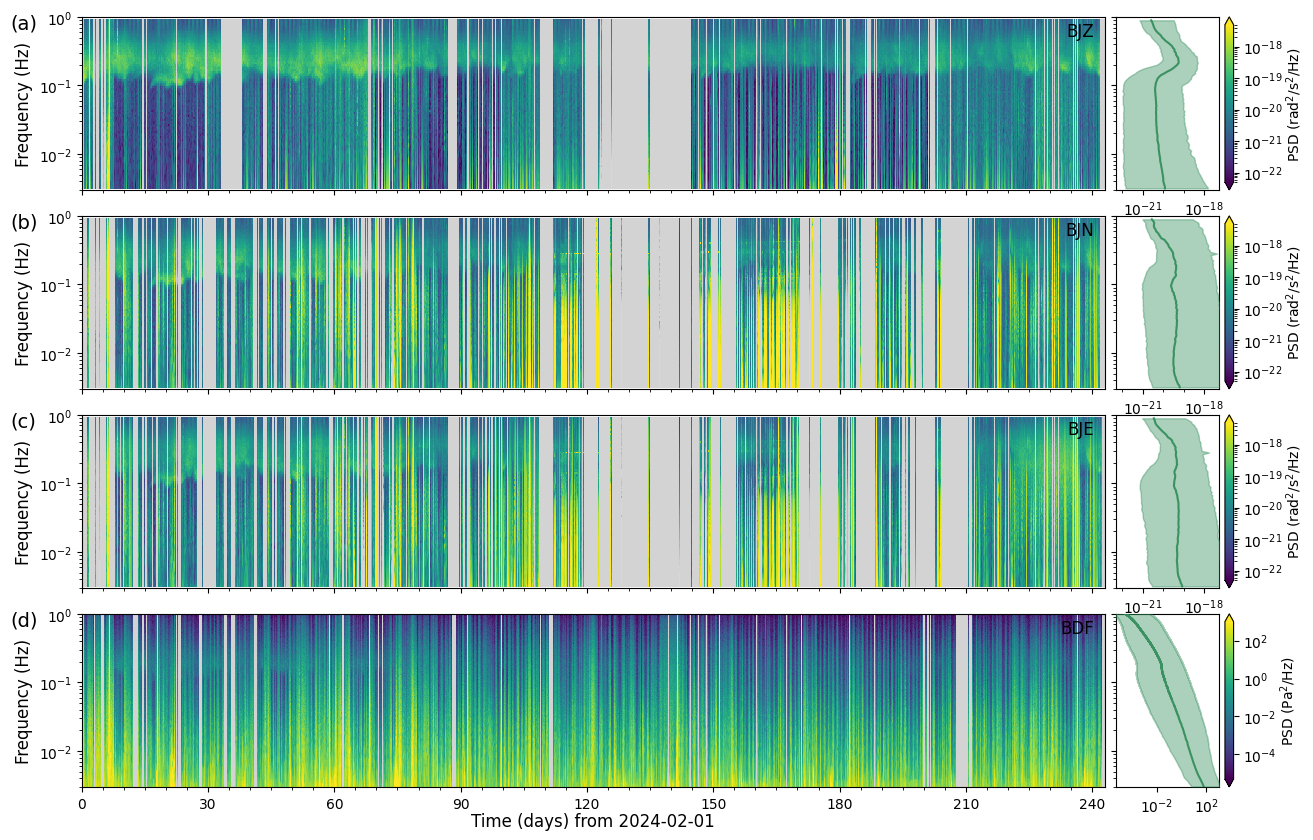

114659

In [12]:
labels = [f"{n.split('_')[1]}" for n in config['names'].values()]

fig = __makeplot_image_overview(
                                [ff_1, ff_2, ff_3, ff_4],
                                [psd_1, psd_2, psd_3, psd_4],
                                [tt_1, tt_2, tt_3, tt_4],
                                labels,
                                )

fig.savefig(config['path_to_figures']+f"TimeSpectra_ROMY_PSD_{config['d1']}_{config['d2']}.png", format="png", dpi=150, bbox_inches='tight')

del fig
gc.collect()

In [13]:
config['names'] = {"Z":"FUR_BHZ", "N":"FUR_BHN", "E":"FUR_BHE", "F":"FFBI_BDF"}

config['fmin'], config['fmax'] = 1e-3, 1e0

config['limits_avg'] = {"Z":1e-13, "N":1e-13, "E":1e-13, "F":None}
config['limits_min'] = {"Z":None, "N":None, "E":None, "F":1e-7}
config['limits_max'] = {"Z":None, "N":None, "E":None, "F":1e6}

config['limits_fmin'] = 0.002
config['limits_fmax'] = 0.05

In [14]:
# Data1 --------------------------
comp = "Z"

ff_1, psd_1 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])
tt_1 = np.arange(0, psd_1.shape[0], 1)

# cut to specified frequency range
psd_1, ff_1 = __cut_frequencies_array(psd_1, ff_1, config['fmin'], config['fmax'])

psd_1, rejected_1 = __replace_noisy_psds_with_nan(psd_1, ff_1,
                                                  threshold_mean=config['limits_avg'][comp],
                                                  threshold_min=config['limits_min'][comp],
                                                  threshold_max=config['limits_max'][comp],
                                                  flim=[config['limits_fmin'], config['limits_fmax']],
                                                  )

ff_1, psd_1 = __get_fband_averages(ff_1, psd_1)

gc.collect();

 -> 0 set to NaN


ValueError: too many values to unpack (expected 2)

In [ ]:
## Data2 --------------------------
comp = "N"

ff_2, psd_2 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])
tt_2 = np.arange(0, psd_2.shape[0], 1)

ff_2, psd_2 = __get_fband_averages(ff_2, psd_2)

psd_2, rejected_2 = __replace_noisy_psds_with_nan(psd_2, ff_2,
                                                  threshold_mean=1e-13,
                                                  threshold_min=None,
                                                  threshold_max=None,
                                                  flim=[0.002, 0.05],
                                                  )
gc.collect();

In [ ]:
## Data3 --------------------------
comp = "E"

ff_3, psd_3 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])
tt_3 = np.arange(0, psd_3.shape[0], 1)

ff_3, psd_3 = __get_fband_averages(ff_3, psd_3)

psd_3, rejected_3 = __replace_noisy_psds_with_nan(psd_3, ff_3,
                                                  threshold_mean=1e-13,
                                                  threshold_min=None,
                                                  threshold_max=None,
                                                  flim=[0.002, 0.05],
                                                  )
gc.collect();

In [ ]:
## Data4 --------------------------
comp = "F"

ff_4, psd_4 = __load_data_files(config['path_to_data'], config['names'][comp], config['d1'], config['d2'])
tt_4 = np.arange(0, psd_3.shape[0], 1)

## cut to specified frequency range
psd_4, ff_4 = __cut_frequencies_array(psd_4, ff_4, 1e-3, 5e0)

## median for octave bands
# ff_4, psd_4 = __get_fband_averages(ff_4, psd_4)

## filter corrupt psds
psd_4, rejected_4 = __replace_noisy_psds_with_nan(psd_4, ff_4,
                                                  threshold_mean=None,
                                                  threshold_min=1e-7,
                                                  threshold_max=1e5,
                                                  flim=[None, None],
                                                  )
gc.collect();

In [ ]:
def __makeplot_image_overview(ff, psds, times, names):

    import gc
    from numpy import isnan, median, mean, std, array, zeros, nanmax, nanmin, shape, nanpercentile
    from scipy.stats import median_abs_deviation as mad
    from matplotlib import colors

    # convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)
    # pp[0] = 0

    ## define colormap
    cmap = plt.colormaps.get_cmap('viridis')
    cmap.set_bad(color='lightgrey')
#     cmap.set_under(color='black')
#     cmap.set_over(color='white')

    min0 = nanpercentile(psds[0].reshape(1, psds[0].size), 5)
    max0 = nanpercentile(psds[0].reshape(1, psds[0].size), 95)


    ##____________________________

    N = int(24*365)

    font = 12

    fig = plt.figure(constrained_layout=False, figsize=(15, 10))
    widths = [8, 1]
    heights = [1, 1, 1, 1]

    spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=widths, height_ratios=heights)

    plt.subplots_adjust(hspace=0.15, wspace=0.02)

    ax1_1 = fig.add_subplot(spec[0, 0])
    ax1_2 = fig.add_subplot(spec[0, 1], sharey=ax1_1)
    ax2_1 = fig.add_subplot(spec[1, 0], sharex=ax1_1)
    ax2_2 = fig.add_subplot(spec[1, 1])
    ax3_1 = fig.add_subplot(spec[2, 0], sharex=ax1_1)
    ax3_2 = fig.add_subplot(spec[2, 1])
    ax4_1 = fig.add_subplot(spec[3, 0], sharex=ax1_1)
    ax4_2 = fig.add_subplot(spec[3, 1])

    im1 = ax1_1.pcolormesh( times[0]/24, ff[0], psds[0].T,
                            cmap=cmap,
                            norm=colors.LogNorm(2e-20, 2e-10),
                            rasterized=True,
                            )
    im2 = ax2_1.pcolormesh( times[1]/24, ff[1], psds[1].T,
                            cmap=cmap,
                            norm=colors.LogNorm(2e-20, 2e-10),
                            rasterized=True,
                            )
    im3 = ax3_1.pcolormesh( times[2]/24, ff[2], psds[2].T,
                            cmap=cmap,
                            norm=colors.LogNorm(2e-20, 2e-10),
                            rasterized=True,
                            )
    im4 = ax4_1.pcolormesh( times[3]/24, ff[3], psds[3].T,
                            cmap=cmap,
                            norm=colors.LogNorm(1e-6, 1e3),
                            rasterized=True,
                            )
    set_color = "seagreen"

    perc_lower, perc_upper = __get_percentiles(psds[0], p_low=2.5, p_high=97.5)
    ax1_2.fill_betweenx(ff[0], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax1_2.plot(__get_median_psd(psds[0]), ff[0], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles(psds[1], p_low=2.5, p_high=97.5)
    ax2_2.fill_betweenx(ff[1], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax2_2.plot(__get_median_psd(psds[1]), ff[1], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles(psds[2], p_low=2.5, p_high=97.5)
    ax3_2.fill_betweenx(ff[2], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax3_2.plot(__get_median_psd(psds[2]), ff[2], color=set_color, zorder=3, alpha=0.9, label="Median")

    perc_lower, perc_upper = __get_percentiles(psds[3], p_low=2.5, p_high=97.5)
    ax4_2.fill_betweenx(ff[3], perc_lower, perc_upper, color=set_color, zorder=3, alpha=0.4, label="")
    ax4_2.plot(__get_median_psd(psds[3]), ff[3], color=set_color, zorder=3, alpha=0.9, label="Median")


    ax1_2.set_xlim(2e-20, 2e-10)
    ax2_2.set_xlim(2e-20, 2e-10)
    ax3_2.set_xlim(2e-20, 2e-10)
    ax4_2.set_xlim(1e-6, 1e3)

    ax4_2.set_xscale("log")

    plt.setp(ax1_1.get_xticklabels(), visible=False)
    plt.setp(ax2_1.get_xticklabels(), visible=False)
    plt.setp(ax3_1.get_xticklabels(), visible=False)

#     plt.setp(ax1_2.get_xticklabels(), visible=False)
#     plt.setp(ax2_2.get_xticklabels(), visible=False)

    plt.setp(ax1_2.get_yticklabels(), visible=False)
    plt.setp(ax2_2.get_yticklabels(), visible=False)
    plt.setp(ax3_2.get_yticklabels(), visible=False)
    plt.setp(ax4_2.get_yticklabels(), visible=False)


    for ax in [ax1_1, ax1_2, ax2_1, ax2_2, ax3_1, ax3_2, ax4_1, ax4_2]:
        ax.tick_params(labelsize=font-2)
        ax.set_ylim(1e-2, 5e0)
        ax.set_yscale("log")

    ax1_2.set_xscale("logit")
    ax2_2.set_xscale("logit")
    ax3_2.set_xscale("logit")

    ax4_1.set_xlabel("Time (days)", fontsize=font, labelpad=1)
    # ax3_2.set_xlabel("PSD (m$^2$/s$^4$/Hz)", fontsize=font, labelpad=1)
    # ax3_2.set_xlabel(r"", fontsize=font, labelpad=-1)

    # new_ticks = [int(round(t/24, 0)) for t in ax3_1.get_xticks()]
    # ax3_1.set_xticklabels(new_ticks)

#     ## panel labels
    ax1_1.text(-.08, .99, '(a)', ha='left', va='top', transform=ax1_1.transAxes, fontsize=font+2)
    ax2_1.text(-.08, .99, '(b)', ha='left', va='top', transform=ax2_1.transAxes, fontsize=font+2)
    ax3_1.text(-.08, .99, '(c)', ha='left', va='top', transform=ax3_1.transAxes, fontsize=font+2)
    ax4_1.text(-.08, .99, '(d)', ha='left', va='top', transform=ax4_1.transAxes, fontsize=font+2)

#     ## data labels
    ax1_1.text(.99, .97, f'{names[0]}', ha='right', va='top', transform=ax1_1.transAxes, fontsize=font)
    ax2_1.text(.99, .97, f'{names[1]}', ha='right', va='top', transform=ax2_1.transAxes, fontsize=font)
    ax3_1.text(.99, .97, f'{names[2]}', ha='right', va='top', transform=ax3_1.transAxes, fontsize=font)
    ax4_1.text(.99, .97, f'{names[3]}', ha='right', va='top', transform=ax4_1.transAxes, fontsize=font)

    ax1_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax2_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax3_1.set_ylabel(r"Frequency (Hz)", fontsize=font)
    ax4_1.set_ylabel(r"Frequency (Hz)", fontsize=font)

#     ## set colorbar at bottom
    cbar = fig.colorbar(im1, orientation='vertical', ax=ax1_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (m$^2$/$s^4$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im2, orientation='vertical', ax=ax2_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (m$^2$/$s^4$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im3, orientation='vertical', ax=ax3_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (m$^2$/$s^4$/Hz)", fontsize=font-2, labelpad=1)

    cbar = fig.colorbar(im4, orientation='vertical', ax=ax4_2, pad=0.05, extend="both")
    cbar.set_label(r"PSD (Pa$^2$/Hz)", fontsize=font-2, labelpad=1)

    gc.collect()

    plt.show();
    return fig

In [ ]:
labels = [f"{n.split('_')[1]}" for n in config['names'].values()]

fig = __makeplot_image_overview(
                                [ff_1, ff_2, ff_3, ff_4],
                                [psd_1, psd_2, psd_3, psd_4],
                                [tt_1, tt_2, tt_3, tt_4],
                                labels,
                                )

fig.savefig(config['path_to_figures']+f"TimeSpectra_FUR_PSD_{config['d1']}_{config['d2']}.png", format="png", dpi=150, bbox_inches='tight')
